<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/Migration_Flowpath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

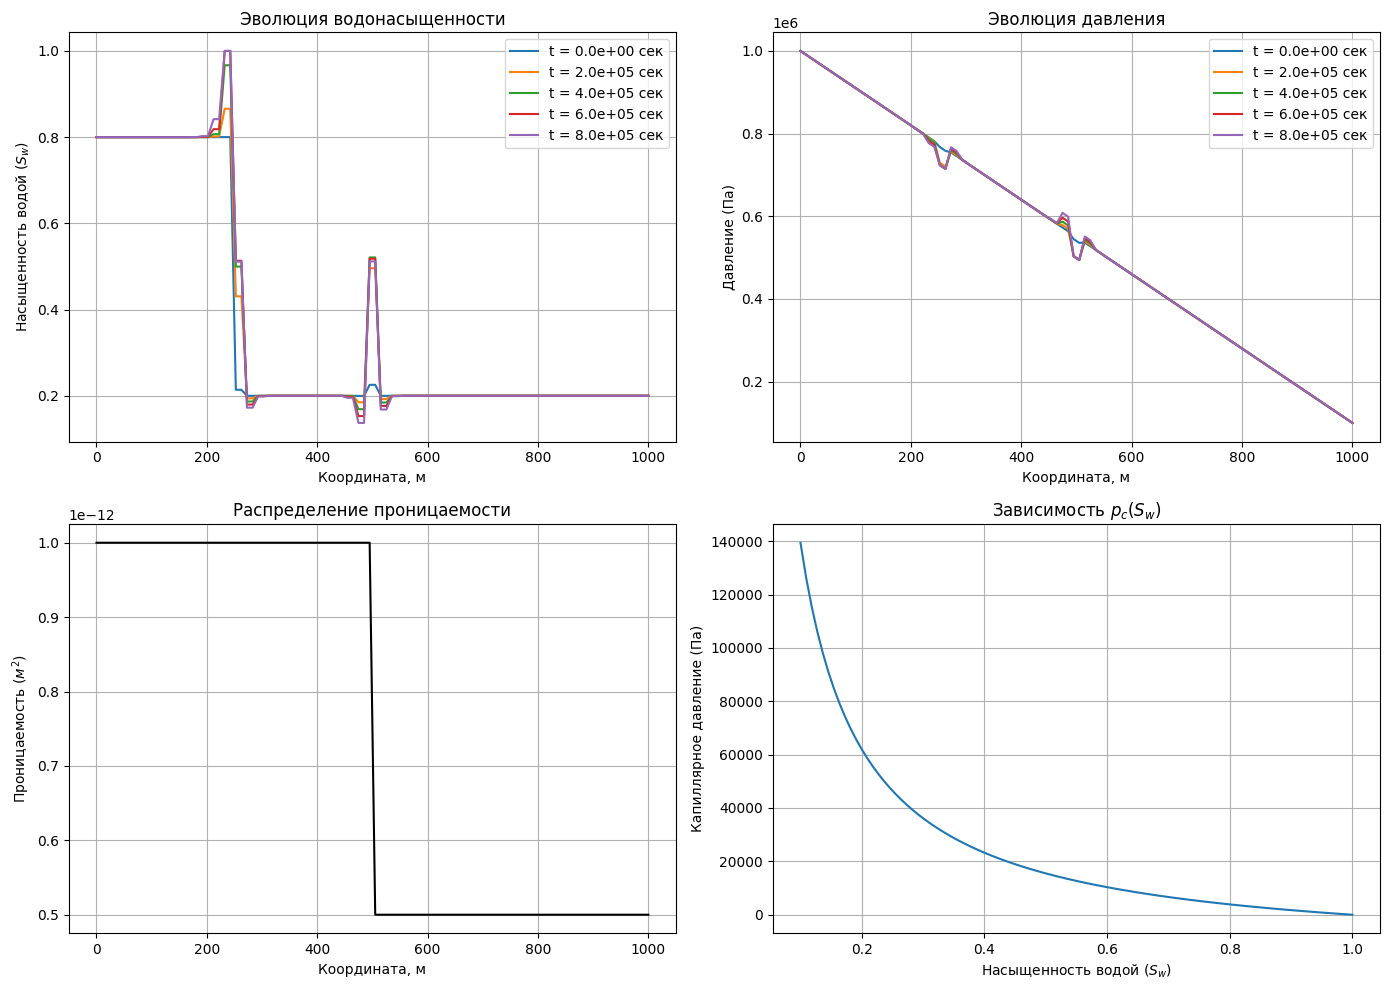

In [1]:
import numpy as np
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import diags, csr_matrix, hstack, vstack
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# Параметры модели
L = 1000.0  # Длина области (м)
nx = 100    # Число узлов
x = np.linspace(0, L, nx)  # Координатная сетка
dx = L / (nx - 1)  # Шаг по пространству
T = 1e6     # Общее время (сек)
nt = 100    # Число шагов по времени
dt = T / nt # Шаг по времени

# Физические параметры
mu_o = 1e-3   # Вязкость нефти (Па·с)
mu_w = 0.5e-3 # Вязкость воды (Па·с)
phi = 0.2     # Пористость
rho_o = 800   # Плотность нефти (кг/м³)
rho_w = 1000  # Плотность воды (кг/м³)
g = 9.81      # Ускорение свободного падения (м/с²)
pin = 1e6     # Давление на входе (Па)
pout = 1e5    # Давление на выходе (Па)
sigma = 0.03  # Поверхностное натяжение (Н/м)

# Проницаемость (гетерогенный пласт)
k = np.ones(nx) * 1e-12  # Базовая проницаемость (м²)
k[nx//2:] = 5e-13        # Уменьшение проницаемости во второй половине

# Начальные условия
Sw0 = np.ones(nx) * 0.2   # Начальная насыщенность водой
Sw0[:nx//4] = 0.8         # Зона с высокой водонасыщенностью
p0 = pin + (pout - pin) * np.linspace(0, 1, nx)  # Линейное начальное давление

# Капиллярное давление (модель Брукса-Кори)
def pc(Sw):
    return sigma * np.sqrt(phi / np.mean(k)) * (1.0 / (Sw + 1e-5) - 1.0)

# Относительные проницаемости (модель Кори)
def kro(Sw):
    return (1 - Sw)**2

def krw(Sw):
    return Sw**3

def solve_implicit(Sw_old, p_old, dt):
    Sw_new = Sw_old.copy()
    p_new = p_old.copy()

    for _ in range(5):
        pc_val = pc(Sw_new)
        dpc_dSw = sigma * np.sqrt(phi / np.mean(k)) / (Sw_new**2 + 1e-5)

        po = p_new
        pw = po - pc_val

        dpodx = np.gradient(po, dx)
        dpwdx = np.gradient(pw, dx)
        u_o = -(k / mu_o) * (dpodx - rho_o * g)
        u_w = -(k / mu_w) * (dpwdx - rho_w * g)

        R_Sw = phi * (Sw_new - Sw_old) / dt + np.gradient(u_w, dx)
        R_p = phi * (1 - Sw_new - (1 - Sw_old)) / dt + np.gradient(u_o, dx)

        # Явное создание разреженных диагональных матриц
        J11 = diags(phi / dt + krw(Sw_new) * dpc_dSw / (mu_w * dx**2), 0)
        J12 = diags(krw(Sw_new) / (mu_w * dx**2), 0)
        J21 = diags(-phi / dt + kro(Sw_new) * dpc_dSw / (mu_o * dx**2), 0)
        J22 = diags(kro(Sw_new) / (mu_o * dx**2), 0)

        # Используем sparse hstack и vstack
        J_top = hstack([J11, J12])
        J_bottom = hstack([J21, J22])
        J = vstack([J_top, J_bottom]).tocsr()  # Явное преобразование в CSR

        dX = spsolve(J, np.concatenate([-R_Sw, -R_p]))
        Sw_new += dX[:nx]
        p_new += dX[nx:]

        Sw_new = np.clip(Sw_new, 0.0, 1.0)

    return Sw_new, p_new

# Основной цикл моделирования
Sw = Sw0.copy()
p = p0.copy()

Sw_history = np.zeros((nx, nt))
p_history = np.zeros((nx, nt))

for it in range(nt):
    Sw, p = solve_implicit(Sw, p, dt)
    Sw_history[:, it] = Sw
    p_history[:, it] = p

# Визуализация
plt.figure(figsize=(14, 10))

# Насыщенность водой
plt.subplot(2, 2, 1)
for it in range(0, nt, max(1, nt // 5)):
    plt.plot(x, Sw_history[:, it], label=f't = {it * dt:.1e} сек')
plt.xlabel('Координата, м')
plt.ylabel('Насыщенность водой ($S_w$)')
plt.title('Эволюция водонасыщенности')
plt.legend()
plt.grid()

# Давление
plt.subplot(2, 2, 2)
for it in range(0, nt, max(1, nt // 5)):
    plt.plot(x, p_history[:, it], label=f't = {it * dt:.1e} сек')
plt.xlabel('Координата, м')
plt.ylabel('Давление (Па)')
plt.title('Эволюция давления')
plt.legend()
plt.grid()

# Проницаемость
plt.subplot(2, 2, 3)
plt.plot(x, k, 'k-')
plt.xlabel('Координата, м')
plt.ylabel('Проницаемость ($м^2$)')
plt.title('Распределение проницаемости')
plt.grid()

# Капиллярное давление
plt.subplot(2, 2, 4)
Sw_plot = np.linspace(0.1, 1.0, 100)
plt.plot(Sw_plot, pc(Sw_plot))
plt.xlabel('Насыщенность водой ($S_w$)')
plt.ylabel('Капиллярное давление (Па)')
plt.title('Зависимость $p_c(S_w)$')
plt.grid()

plt.tight_layout()
plt.show()

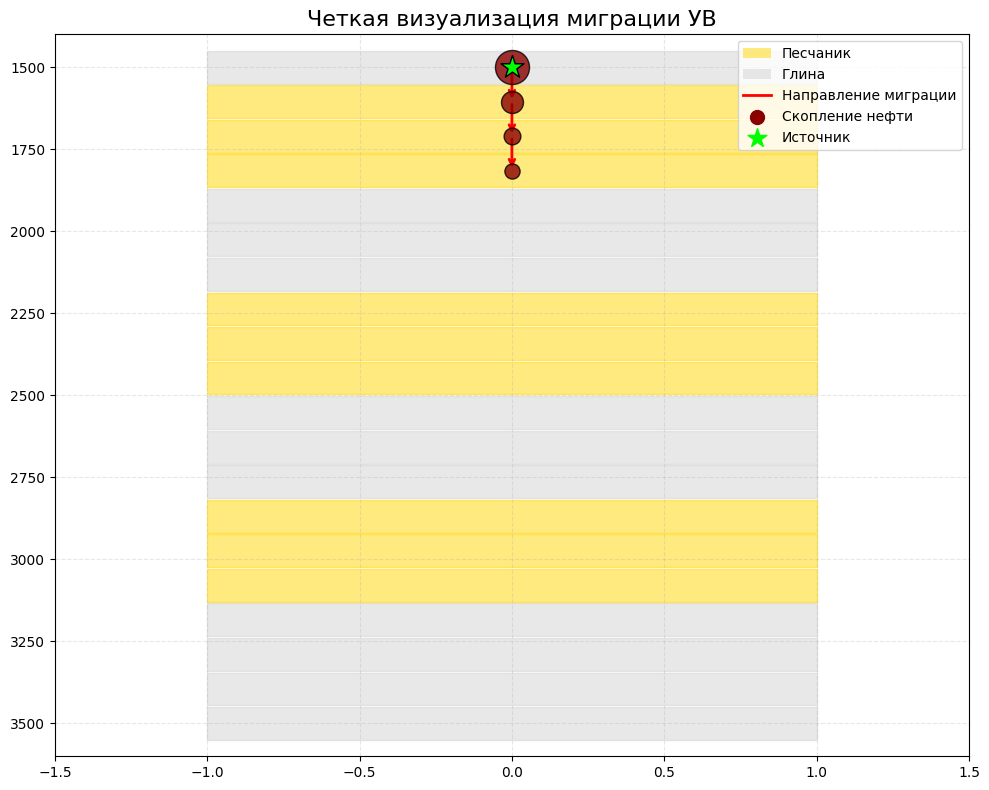

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def dynamic_migration_model():
    # Параметры модели (источник строго внизу)
    n_layers = 20
    depths = np.linspace(3500, 1500, n_layers)  # 3.5 км (низ) -> 1.5 км (верх)

    # Явные коллекторы (3 песчаных пласта)
    lithology = np.array(['shale']*n_layers)
    lithology[4:7] = 'sand'  # Коллектор 1 (глубокий)
    lithology[10:13] = 'sand'  # Коллектор 2
    lithology[16:19] = 'sand'  # Коллектор 3 (ближе к верху)

    # Критические параметры для миграции
    entry_pressure_sand = 0.05e6  # 0.05 МПа
    entry_pressure_shale = 0.5e6  # 0.5 МПа
    entry_pressure = np.where(lithology == 'sand', entry_pressure_sand, entry_pressure_shale)

    # Физические константы
    rho_oil = 780  # кг/м3 (легкая нефть)
    rho_water = 1100  # кг/м3 (соленая вода)
    g = 9.81

    # Инициализация
    oil = np.zeros(n_layers)
    oil[-1] = 5.0  # Большой источник внизу
    migration_mask = np.zeros(n_layers, dtype=bool)
    migration_mask[-1] = True  # Отмечаем источник

    # Моделирование миграции
    for i in range(n_layers-1, 0, -1):  # Снизу вверх!
        if oil[i] > 0:
            # Высота столба нефти
            h = (depths[i-1] - depths[i])  # Положительная величина

            # Давление плавучести
            delta_p = (rho_water - rho_oil) * g * h

            if delta_p > entry_pressure[i-1]:
                oil[i-1] += oil[i] * 0.3  # Переносим 30% нефти
                oil[i] *= 0.7
                migration_mask[i-1] = True

    # Визуализация
    fig, ax = plt.subplots(figsize=(10, 8))

    # Фон - литология
    for i in range(n_layers):
        color = 'gold' if lithology[i] == 'sand' else 'lightgray'
        ax.fill_between([-1, 1], [depths[i]-50, depths[i]-50],
                       [depths[i]+50, depths[i]+50], color=color, alpha=0.5)

    # Пути миграции (красные стрелки)
    for i in range(n_layers-1):
        if migration_mask[i] and migration_mask[i+1]:
            ax.annotate("", xy=(0, depths[i]), xytext=(0, depths[i+1]),
                       arrowprops=dict(arrowstyle="->", color="red", lw=2))

    # Скопления нефти
    for i in range(n_layers):
        if oil[i] > 0.1:  # Показываем только значимые скопления
            size = 100 + 500 * oil[i]/oil.max()
            ax.scatter(0, depths[i], s=size, c='darkred', alpha=0.8,
                      edgecolors='black', zorder=3)

    # Источник (внизу)
    ax.scatter(0, depths[-1], s=300, c='lime', marker='*',
              edgecolors='black', zorder=4)

    # Настройки графика
    ax.invert_yaxis()
    ax.set_title("Четкая визуализация миграции УВ", fontsize=16)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(depths[0]+100, depths[-1]-100)
    ax.grid(True, linestyle='--', alpha=0.3)

    # Легенда
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='gold', alpha=0.5, label='Песчаник'),
        Patch(facecolor='lightgray', alpha=0.5, label='Глина'),
        plt.Line2D([0], [0], color='red', lw=2, label='Направление миграции'),
        plt.scatter([], [], s=100, c='darkred', label='Скопление нефти'),
        plt.scatter([], [], s=200, c='lime', marker='*', label='Источник')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

dynamic_migration_model()